# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import pandas as pd
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from skimage.io import imshow, imread
from tqdm import tqdm

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/home/danil/PycharmProjects/Alice/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
need_class = ['car', 'motorcycle', 'bicycle', 'person', 'truck', 'bus']
need_class_id = [class_names.index(x) for x in need_class]
print (need_class_id)

[3, 4, 2, 1, 8, 6]


## Run Object Detection

In [ ]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
# random.choice(file_names) '170908_061502408_Camera_5.jpg'
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]

In [ ]:
need_classes =  [x for x in range(r['class_ids'].shape[-1])  if r['class_ids'][x] in need_class_id]
r['class_ids'] = r['class_ids'][need_classes]
r['scores'] = r['scores'][need_classes]
r['rois'] = r['rois'][need_classes]
r['masks'] = r['masks'][:,:,need_classes]

In [ ]:
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [ ]:
m = np.ones((image.shape[0], image.shape[1]))*r['masks'][:,:,0]*r['scores'][0]
skimage.io.imshow(m)

In [ ]:
m.max()

# 3- Result Submission

In [40]:
def get_postprocess_pixels(arr):
    out_str = str(arr[0])
    count = 0
    pixel_count = len(arr)
    for i in range(1,len(arr)):
        count += 1
        if arr[i]-arr[i-1]!=1:
            out_str += ' ' + str(count) + '|' + str(arr[i])
            count = 0
    return out_str + ' ' + str(count) + '|', pixel_count

def get_Encoder_pixels(img):
    arr = list()
    m = img.shape[0]
    n = img.shape[1]
    lab_img = np.argwhere(img >= 0.5) 
    for i in lab_img:
        arr.append(n*i[0]+i[1])
    return arr

In [41]:
submission = pd.DataFrame(columns = ['ImageId','LabelId','Confidence','PixelCount','EncodedPixels'])
IMAGE_TEST_DIR = '/media/danil/Data/Kaggle/CVPR 2018/input/test'
name_images = os.listdir(IMAGE_TEST_DIR)

cnt = 0
for image_name in tqdm(name_images):
    image = imread(os.path.join(IMAGE_TEST_DIR, image_name))
    ones = np.ones((image.shape[0], image.shape[1]))
    # Run detection
    r = model.detect([image], verbose=0)[0]
    need_classes =  [x for x in range(r['class_ids'].shape[-1])  if r['class_ids'][x] in need_class_id]
    r['class_ids'] = r['class_ids'][need_classes]
    r['scores'] = r['scores'][need_classes]
    r['rois'] = r['rois'][need_classes]
    r['masks'] = r['masks'][:,:,need_classes]
    for instance in range(r['class_ids'].shape[0]):
        mask = ones*r['masks'][:,:,instance]*r['scores'][instance]
        encoded_puxels = get_Encoder_pixels(mask)
        if len(encoded_puxels)==0:
            continue
        encoded_pixels, pixel_count = get_postprocess_pixels(encoded_puxels)
        submission.loc[cnt] = [image_name.split('.jp')[0], r['class_ids'][instance], r['scores'][instance], \
                               pixel_count, encoded_pixels]
        cnt += 1
    
submission.to_csv('Sub-wad-video-seg.csv', index=False)

100%|██████████| 1917/1917 [59:08<00:00,  1.85s/it]


In [42]:
submission.head(10)

,ImageId,LabelId,Confidence,PixelCount,EncodedPixels
0,1d21b2572cede8cda5419d572c852cea,3,0.997207,59512,6228998 66|6232371 92|6235745 117|6239124 156|...
1,1d21b2572cede8cda5419d572c852cea,3,0.992767,12820,5840913 59|5844286 79|5847664 90|5851044 98|58...
2,1d21b2572cede8cda5419d572c852cea,3,0.991453,19833,6140502 2|6143875 58|6147254 74|6150636 82|615...
3,1d21b2572cede8cda5419d572c852cea,3,0.985488,20336,5851385 65|5854759 98|5858136 127|5861515 144|...
4,1d21b2572cede8cda5419d572c852cea,3,0.974251,63880,5977789 136|5981161 169|5984541 181|5987923 18...
5,1d21b2572cede8cda5419d572c852cea,3,0.973440,6348,6141456 52|6144834 74|6148214 87|6151596 94|61...
6,1d21b2572cede8cda5419d572c852cea,3,0.962117,12585,5932988 60|5936362 80|5939741 90|5943122 96|59...
7,1d21b2572cede8cda5419d572c852cea,3,0.928546,6979,5991633 1|5995008 75|5998385 100|5998486 24|60...
8,1d21b2572cede8cda5419d572c852cea,3,0.856663,26542,5896132 96|5899506 134|5902884 154|5906261 169...
9,bd425cc5f0a762b161984b53bd868ac4,6,0.998738,487503,4825633 2|4829014 11|4832394 21|4835775 29|483...


/home/danil/PycharmProjects/Alice/venv/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/danil/PycharmProjects/Alice/venv/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


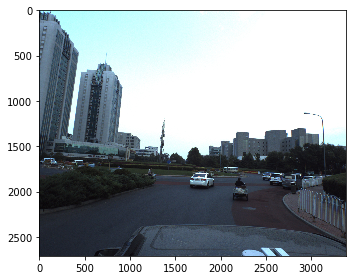

In [27]:
imshow(image)

In [17]:
submission2=submission.copy()

In [43]:
submission['LabelId'] = submission['LabelId'].map({3:33, 4:34, 2: 35, 1:36, 8:38, 6:39})
submission.to_csv('Sub-wad-video-seg4.csv', index=False)

# Validation

In [38]:
submission['Confidence'] = np.ones((15900))
submission.to_csv('Sub-wad-video-seg3.csv', index=False)